<a href="https://colab.research.google.com/github/Yasir323/100-days-of-code/blob/master/Threading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### References: 
1. <a href="https://realpython.com/intro-to-python-threading/"> Real Python</a>
2. <a href="https://www.geeksforgeeks.org/multithreading-python-set-1/"> GfG - Multithreading</a>
3. <a href="https://www.geeksforgeeks.org/multithreading-in-python-set-2-synchronization/"> GfG - Deadlocks</a>
4. <a href="https://creativedata.stream/multi-threading-api-requests-in-python/">Multi-threading API Requests</a>
5. <a href="https://krondo.com/in-which-we-begin-at-the-beginning/">Threading vs Async</a>
6. <a href="https://medium.com/vaidikkapoor/understanding-non-blocking-i-o-with-python-part-1-ec31a2e2db9b">Understanding Non Blocking I/O with Python</a>
7. <a href="https://stackoverflow.com/questions/4024056/threads-vs-async/4024385">Threads vs Async</a>
8. <a href="https://realpython.com/python-async-features/">Async</a>

### Starting a Thread

In [1]:
import threading
import time

In [2]:
def thread_function(name):
    print("Thread {}: starting".format(name))
    time.sleep(2)
    print("Thread {}: finishing".format(name))

In [3]:
print("Main    : before creating thread")
x = threading.Thread(target=thread_function, args=(1,))
print("Main    : before running thread")
x.start()
print("Main    : wait for the thread to finish")
# x.join()
print("Main    : all done")

Main    : before creating thread
Main    : before running thread
Thread 1: startingMain    : wait for the thread to finish

Main    : all done


> The Program is not waiting for Thread to finish. This is a problem in Google Colab only.
**This should be the output:**
```
Main    : before creating thread
Main    : before running thread        
Thread 1: starting
Main    : wait for the thread to finish
Main    : all done
Thread 1: finishing
```

When you create a Thread, you pass it a function and a list containing the arguments to that function. In this case, you’re telling the Thread to run thread_function() and to pass it 1 as an argument.

You’ll notice that the Thread finished after the Main section of your code did. You’ll come back to why that is and talk about the mysterious line twenty in the next section.

### Daemon Threads
In computer science, a daemon is a process that runs in the background.
Python threading has a more specific meaning for daemon. A daemon thread will shut down immediately when the program exits.

If a program is running Threads that are not daemons, then the program will wait for those threads to complete before it terminates. Threads that are daemons, however, are just killed wherever they are when the program is exiting.

Let’s look a little more closely at the output of your program above. The last two lines are the interesting bit. When you run the program, you’ll notice that there is a pause (of about 2 seconds) after `__main__` has printed its all done message and before the thread is finished.

This pause is Python waiting for the non-daemonic thread to complete. When your Python program ends, part of the shutdown process is to clean up the threading routine.

If you look at the source for Python threading, you’ll see that threading._shutdown() walks through all of the running threads and calls .join() on every one that does not have the daemon flag set.

In [4]:
print("Main    : before creating thread")
x = threading.Thread(target=thread_function, args=(1,), daemon=True)
print("Main    : before running thread")
x.start()
print("Main    : wait for the thread to finish")
# x.join()
print("Main    : all done")

Main    : before creating thread
Main    : before running thread
Thread 1: starting
Main    : wait for the thread to finish
Main    : all done


The difference here is that the final line of the output is missing. thread_function() did not get a chance to complete. It was a daemon thread, so when `__main__` reached the end of its code and the program wanted to finish, the daemon was killed.

Daemon threads are handy, but what about when you want to wait for a thread to stop? What about when you want to do that and not exit your program?

To tell one thread to wait for another thread to finish, you call .join(). If you uncomment that line, the main thread will pause and wait for the thread x to complete running.

In [5]:
print("Main    : before creating thread")
x = threading.Thread(target=thread_function, args=(1,))
print("Main    : before running thread")
x.start()
print("Main    : wait for the thread to finish")
x.join()
print("Main    : all done")

Main    : before creating thread
Main    : before running thread
Thread 1: startingMain    : wait for the thread to finish

Thread 1: finishing
Thread 1: finishing
Thread 1: finishing
Main    : all done


### Working With Many Threads

In [6]:
threads = []
for index in range(3):
  print("Main    : create and start thread {}.".format(index))
  x = threading.Thread(target=thread_function, args=(index,))
  threads.append(x)
  x.start()
for index, thread in enumerate(threads):
  print("Main    : before joining thread {}.".format(index))
  thread.join()
  print("Main    : thread {} done".format(index))

Main    : create and start thread 0.
Thread 0: starting
Main    : create and start thread 1.
Thread 1: startingMain    : create and start thread 2.

Thread 2: startingMain    : before joining thread 0.

Thread 0: finishing
Main    : thread 0 done
Main    : before joining thread 1.
Thread 1: finishing
Main    : thread 1 done
Main    : before joining thread 2.
Thread 2: finishing
Main    : thread 2 done


This code uses the same mechanism you saw above to start a thread, create a Thread object, and then call .start(). The program keeps a list of Thread objects so that it can then wait for them later using .join().

Running this code multiple times will likely produce some interesting results.

If you walk through the output carefully, you’ll see all three threads getting started in the order you might expect, but in this case they finish in the opposite order! Multiple runs will produce different orderings. Look for the Thread x: finishing message to tell you when each thread is done.

The order in which threads are run is determined by the operating system and can be quite hard to predict. It may (and likely will) vary from run to run, so you need to be aware of that when you design algorithms that use threading.

### Using a ThreadPoolExecutor
There’s an easier way to start up a group of threads than the one you saw above. It’s called a ThreadPoolExecutor, and it’s part of the standard library in concurrent.futures (as of Python 3.2).

The easiest way to create it is as a context manager, using the with statement to manage the creation and destruction of the pool.

In [7]:
import random

In [8]:
import concurrent.futures

In [9]:
with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
  executor.map(thread_function, range(3))

Thread 0: starting
Thread 1: starting
Thread 2: starting
Thread 0: finishing
Thread 1: finishing
Thread 2: finishing


The code creates a ThreadPoolExecutor as a context manager, telling it how many worker threads it wants in the pool. It then uses .map() to step through an iterable of things, in your case range(3), passing each one to a thread in the pool.

The end of the with block causes the ThreadPoolExecutor to do a .join() on each of the threads in the pool. It is strongly recommended that you use ThreadPoolExecutor as a context manager when you can so that you never forget to .join() the threads.

> **Note:** Using a ThreadPoolExecutor can cause some confusing errors.
For example, if you call a function that takes no parameters, but you pass it parameters in .map(), the thread will throw an exception.
Unfortunately, ThreadPoolExecutor will hide that exception, and (in the case above) the program terminates with no output. This can be quite confusing to debug at first.

### Race Conditions
Race conditions can occur when two or more threads access a shared piece of data or resource. In this example, you’re going to create a large race condition that happens every time, but be aware that most race conditions are not this obvious. Frequently, they only occur rarely, and they can produce confusing results. As you can imagine, this makes them quite difficult to debug.

In [10]:
class FakeDatabase:
    def __init__(self):
        self.value = 0

    def update(self, name):
        print("Thread {}: starting update".format(name))
        local_copy = self.value
        local_copy += 1
        time.sleep(0.1)
        self.value = local_copy
        print("Thread {}: finishing update".format(name))

FakeDatabase is keeping track of a single number: .value. This is going to be the shared data on which you’ll see the race condition.

`.__init__()` simply initializes .value to zero. So far, so good.

.update() looks a little strange. It’s simulating reading a value from a database, doing some computation on it, and then writing a new value back to the database.

In this case, reading from the database just means copying .value to a local variable. The computation is just to add one to the value and then .sleep() for a little bit. Finally, it writes the value back by copying the local value back to .value.

In [11]:
database = FakeDatabase()
print("Testing update. Starting value is {}.".format(database.value))
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    for index in range(2):
        executor.submit(database.update, index)
print("Testing update. Ending value is {}.".format(database.value))

Testing update. Starting value is 0.
Thread 0: starting update
Thread 1: starting update
Thread 0: finishing update
Thread 1: finishing update
Testing update. Ending value is 1.


The program creates a ThreadPoolExecutor with two threads and then calls .submit() on each of them, telling them to run database.update().

Since each thread runs .update(), and .update() adds one to .value, you might expect database.value to be 2 when it’s printed out at the end. But its actually 1.

#### One Thread

When you tell your ThreadPoolExecutor to run each thread, you tell it which function to run and what parameters to pass to it: executor.submit(database.update, index).

The result of this is that each of the threads in the pool will call database.update(index). Note that database is a reference to the one FakeDatabase object created in `__main__`. Calling .update() on that object calls an instance method on that object.

Each thread is going to have a reference to the same FakeDatabase object, database. Each thread will also have a unique value, index, to make the logging statements a bit easier to read:

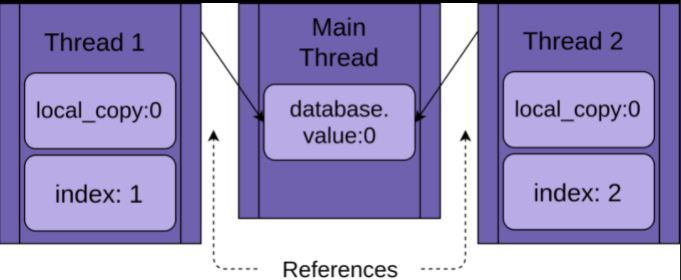

When the thread starts running .update(), it has its own version of all of the data local to the function. In the case of .update(), this is local_copy. This is definitely a good thing. Otherwise, two threads running the same function would always confuse each other. It means that all variables that are scoped (or local) to a function are thread-safe.

Now you can start walking through what happens if you run the program above with a single thread and a single call to .update().

The image below steps through the execution of .update() if only a single thread is run. The statement is shown on the left followed by a diagram showing the values in the thread’s local_copy and the shared database.value:

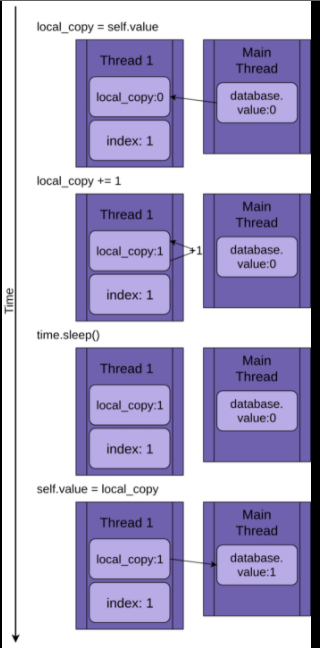

When Thread 1 starts, FakeDatabase.value is zero. The first line of code in the method, local_copy = self.value, copies the value zero to the local variable. Next it increments the value of local_copy with the local_copy += 1 statement. You can see .value in Thread 1 getting set to one.

Next time.sleep() is called, which makes the current thread pause and allows other threads to run. Since there is only one thread in this example, this has no effect.

When Thread 1 wakes up and continues, it copies the new value from local_copy to FakeDatabase.value, and then the thread is complete. You can see that database.value is set to one.

So far, so good. You ran .update() once and FakeDatabase.value was incremented to one.

#### Two threads
Getting back to the race condition, the two threads will be running concurrently but not at the same time. They will each have their own version of local_copy and will each point to the same database. It is this shared database object that is going to cause the problems.

The program starts with Thread 1 running .update():

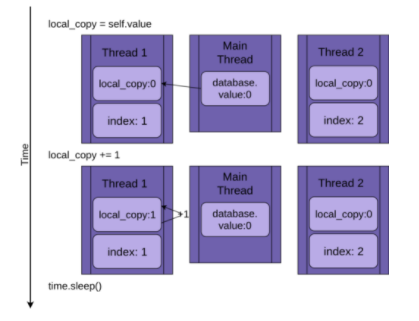

When Thread 1 calls time.sleep(), it allows the other thread to start running. This is where things get interesting.

Thread 2 starts up and does the same operations. It’s also copying database.value into its private local_copy, and this shared database.value has not yet been updated:

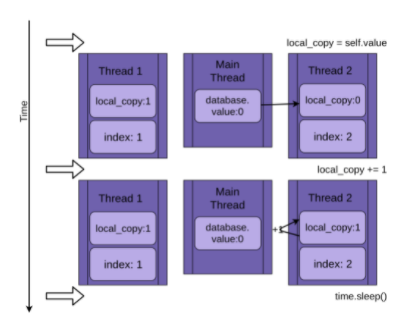

When Thread 2 finally goes to sleep, the shared database.value is still unmodified at zero, and both private versions of local_copy have the value one.

Thread 1 now wakes up and saves its version of local_copy and then terminates, giving Thread 2 a final chance to run. Thread 2 has no idea that Thread 1 ran and updated database.value while it was sleeping. It stores its version of local_copy into database.value, also setting it to one:

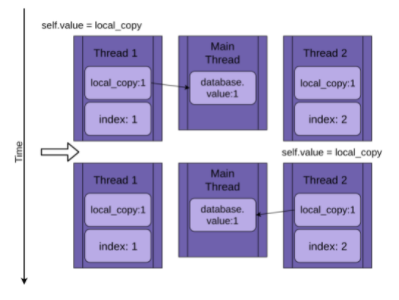

### Basic Synchronization Using Lock

To solve your race condition above, you need to find a way to allow only one thread at a time into the read-modify-write section of your code. The most common way to do this is called Lock in Python. In some other languages this same idea is called a mutex. Mutex comes from MUTual EXclusion, which is exactly what a Lock does.

A Lock is an object that acts like a hall pass. Only one thread at a time can have the Lock. Any other thread that wants the Lock must wait until the owner of the Lock gives it up.

The basic functions to do this are .acquire() and .release(). A thread will call my_lock.acquire() to get the lock. If the lock is already held, the calling thread will wait until it is released. There’s an important point here. If one thread gets the lock but never gives it back, your program will be stuck.

Fortunately, Python’s Lock will also operate as a context manager, so you can use it in a with statement, and it gets released automatically when the with block exits for any reason.

In [12]:
class FakeDatabase:
    def __init__(self):
        self.value = 0
        self._lock = threading.Lock()

    def locked_update(self, name):
        print("Thread {}: starting update".format(name))
        print(f"Thread {name} about to lock")
        with self._lock:
            print(f"Thread {name} has lock")
            local_copy = self.value
            local_copy += 1
            time.sleep(0.1)
            self.value = local_copy
            print(f"Thread {name} about to release lock")
        print(f"Thread {name} after release")
        print(f"Thread {name}: finishing update")

In [13]:
database = FakeDatabase()
print("Testing update. Starting value is {}.".format(database.value))
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    for index in range(2):
        executor.submit(database.locked_update, index)
print("Testing update. Ending value is {}.".format(database.value))

Testing update. Starting value is 0.
Thread 0: starting update
Thread 0 about to lock
Thread 0 has lock
Thread 1: starting update
Thread 1 about to lock
Thread 0 about to release lock
Thread 0 after release
Thread 0: finishing update
Thread 1 has lock
Thread 1 about to release lock
Thread 1 after release
Thread 1: finishing update
Testing update. Ending value is 2.


### Producer Consumer Problem

The Producer-Consumer Problem is a standard computer science problem used to look at threading or process synchronization issues. You’re going to look at a variant of it to get some ideas of what primitives the Python threading module provides.

For this example, you’re going to imagine a program that needs to read messages from a network and write them to disk. The program does not request a message when it wants. It must be listening and accept messages as they come in. The messages will not come in at a regular pace, but will be coming in bursts. This part of the program is called the producer.

On the other side, once you have a message, you need to write it to a database. The database access is slow, but fast enough to keep up to the average pace of messages. It is not fast enough to keep up when a burst of messages comes in. This part is the consumer.

In between the producer and the consumer, you will create a Pipeline that will be the part that changes as you learn about different synchronization objects.

That’s the basic layout. Let’s look at a solution using Lock. It doesn’t work perfectly, but it uses tools you already know, so it’s a good place to start.

In [14]:
class Pipeline:
    """
    Class to allow a single element pipeline between producer and consumer.
    """
    def __init__(self):
        self.message = 0
        self.producer_lock = threading.Lock()
        self.consumer_lock = threading.Lock()
        self.consumer_lock.acquire()

    def get_message(self, name):
        print(f"{name}:about to acquire getlock")
        self.consumer_lock.acquire()
        print(f"{name}:have getlock")
        message = self.message
        print(f"{name}:about to release setlock")
        self.producer_lock.release()
        print(f"{name}:setlock released")
        return message

    def set_message(self, message, name):
        print(f"{name}:about to acquire setlock")
        self.producer_lock.acquire()
        print(f"{name}:have setlock")
        self.message = message
        print(f"{name}:about to release getlock")
        self.consumer_lock.release()
        print(f"{name}:getlock released")

That seems a bit more manageable. The Pipeline in this version of your code has three members:

    .message stores the message to pass.
    .producer_lock is a threading.Lock object that restricts access to the message by the producer thread.
    .consumer_lock is also a threading.Lock that restricts access to the message by the consumer thread.

__init__() initializes these three members and then calls .acquire() on the .consumer_lock. This is the state you want to start in. The producer is allowed to add a new message, but the consumer needs to wait until a message is present.

.get_message() and .set_messages() are nearly opposites. .get_message() calls .acquire() on the consumer_lock. This is the call that will make the consumer wait until a message is ready.

Once the consumer has acquired the .consumer_lock, it copies out the value in .message and then calls .release() on the .producer_lock. Releasing this lock is what allows the producer to insert the next message into the pipeline.

Before you go on to .set_message(), there’s something subtle going on in .get_message() that’s pretty easy to miss. It might seem tempting to get rid of message and just have the function end with return self.message. See if you can figure out why you don’t want to do that before moving on.

Here’s the answer. As soon as the consumer calls .producer_lock.release(), it can be swapped out, and the producer can start running. That could happen before .release() returns! This means that there is a slight possibility that when the function returns self.message, that could actually be the next message generated, so you would lose the first message. This is another example of a race condition.

Moving on to .set_message(), you can see the opposite side of the transaction. The producer will call this with a message. It will acquire the .producer_lock, set the .message, and the call .release() on then consumer_lock, which will allow the consumer to read that value.

In [15]:
SENTINEL = object()

def producer(pipeline):
    """Pretend we're getting a message from the network."""
    for index in range(10):
        message = random.randint(1, 101)
        print(f"Producer got message: {message}")
        pipeline.set_message(message, "Producer")

    # Send a sentinel message to tell consumer we're done
    pipeline.set_message(SENTINEL, "Producer")

To generate a fake message, the producer gets a random number between one and one hundred. It calls .set_message() on the pipeline to send it to the consumer.

The producer also uses a SENTINEL value to signal the consumer to stop after it has sent ten values. This is a little awkward, but don’t worry, you’ll see ways to get rid of this SENTINEL value after you work through this example.

In [18]:
def consumer(pipeline):
    """Pretend we're saving a number in the database."""
    message = 0
    while message is not SENTINEL:
        message = pipeline.get_message("Consumer")
        if message is not SENTINEL:
            print(f"Consumer storing message: {message}")

The consumer reads a message from the pipeline and writes it to a fake database, which in this case is just printing it to the display. If it gets the SENTINEL value, it returns from the function, which will terminate the thread.

In [19]:
pipeline = Pipeline()
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    executor.submit(producer, pipeline)
    executor.submit(consumer, pipeline)

Producer got message: 28
Producer:about to acquire setlock
Producer:have setlock
Producer:about to release getlock
Producer:getlock released
Producer got message: 39
Producer:about to acquire setlock
Consumer:about to acquire getlock
Consumer:have getlock
Consumer:about to release setlock
Consumer:setlock releasedProducer:have setlock
Producer:about to release getlock
Producer:getlock released
Producer got message: 78
Producer:about to acquire setlock

Consumer storing message: 28
Consumer:about to acquire getlock
Consumer:have getlock
Consumer:about to release setlock
Consumer:setlock released
Consumer storing message: 39
Consumer:about to acquire getlock
Producer:have setlock
Producer:about to release getlock
Producer:getlock released
Producer got message: 75
Producer:about to acquire setlock
Consumer:have getlock
Consumer:about to release setlock
Consumer:setlock released
Consumer storing message: 78
Consumer:about to acquire getlock
Producer:have setlock
Producer:about to release g

At first, you might find it odd that the producer gets two messages before the consumer even runs. If you look back at the producer and .set_message(), you will notice that the only place it will wait for a Lock is when it attempts to put the message into the pipeline. This is done after the producer gets the message and logs that it has it.

When the producer attempts to send this second message, it will call .set_message() the second time and it will block.

The operating system can swap threads at any time, but it generally lets each thread have a reasonable amount of time to run before swapping it out. That’s why the producer usually runs until it blocks in the second call to .set_message().

Once a thread is blocked, however, the operating system will always swap it out and find a different thread to run. In this case, the only other thread with anything to do is the consumer.

The consumer calls .get_message(), which reads the message and calls .release() on the .producer_lock, thus allowing the producer to run again the next time threads are swapped.

Notice that the first message was 43, and that is exactly what the consumer read, even though the producer had already generated the 45 message.

While it works for this limited test, it is not a great solution to the producer-consumer problem in general because it only allows a single value in the pipeline at a time. When the producer gets a burst of messages, it will have nowhere to put them.

### Producer-Consumer Using Queue

If you want to be able to handle more than one value in the pipeline at a time, you’ll need a data structure for the pipeline that allows the number to grow and shrink as data backs up from the producer.

Python’s standard library has a queue module which, in turn, has a Queue class. Let’s change the Pipeline to use a Queue instead of just a variable protected by a Lock. You’ll also use a different way to stop the worker threads by using a different primitive from Python threading, an ***Event***.

Let’s start with the Event. The threading.Event object allows one thread to signal an event while many other threads can be waiting for that event to happen. The key usage in this code is that the threads that are waiting for the event do not necessarily need to stop what they are doing, they can just check the status of the Event every once in a while.

The triggering of the event can be many things. In this example, the main thread will simply sleep for a while and then .set() it:

In [20]:
def producer(pipeline, event):
    """Pretend we're getting a number from the network."""
    while not event.is_set():
        message = random.randint(1, 101)
        print(f"Producer got message: {message}")
        pipeline.set_message(message, "Producer")
    print(f"Producer received EXIT event. Exiting")

Producer now will loop until it sees that the event was set on line 3. It also no longer puts the SENTINEL value into the pipeline.

In [21]:
def consumer(pipeline, event):
    """Pretend we're saving a number in the database."""
    while not event.is_set() or not pipeline.empty():
        message = pipeline.get_message("Consumer")
        print(f"Consumer storing message: {message}  (queue size={pipeline.qsize()})")
    print("Consumer received EXIT event. Exiting")

While you got to take out the code related to the SENTINEL value, you did have to do a slightly more complicated while condition. Not only does it loop until the event is set, but it also needs to keep looping until the pipeline has been emptied.

Making sure the queue is empty before the consumer finishes prevents another fun issue. If the consumer does exit while the pipeline has messages in it, there are two bad things that can happen. The first is that you lose those final messages, but the more serious one is that the producer can get caught attempting to add a message to a full queue and never return.

This happens if the event gets triggered after the producer has checked the .is_set() condition but before it calls pipeline.set_message().

If that happens, it’s possible for the producer to wake up and exit with the queue still completely full. The producer will then call .set_message() which will wait until there is space on the queue for the new message. The consumer has already exited, so this will not happen and the producer will not exit.

The rest of the consumer should look familiar.

In [25]:
import queue

In [26]:
class Pipeline(queue.Queue):
    def __init__(self):
        super().__init__(maxsize=10)

    def get_message(self, name):
        print(f"{name}:about to get from queue")
        value = self.get()
        print(f"{name}:got {value} from queue")
        return value

    def set_message(self, value, name):
        print(f"{name}:about to add {value} to queue")
        self.put(value)
        print(f"{name}:added {value} to queue")

You can see that Pipeline is a subclass of queue.Queue. Queue has an optional parameter when initializing to specify a maximum size of the queue.

If you give a positive number for maxsize, it will limit the queue to that number of elements, causing .put() to block until there are fewer than maxsize elements. If you don’t specify maxsize, then the queue will grow to the limits of your computer’s memory.

.get_message() and .set_message() got much smaller. They basically wrap .get() and .put() on the Queue. You might be wondering where all of the locking code that prevents the threads from causing race conditions went.

The core devs who wrote the standard library knew that a Queue is frequently used in multi-threading environments and incorporated all of that locking code inside the Queue itself. Queue is thread-safe.

In [27]:
pipeline = Pipeline()
event = threading.Event()
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    executor.submit(producer, pipeline, event)
    executor.submit(consumer, pipeline, event)
    
    time.sleep(0.1)
    print(f"Main: about to set event")
    event.set()

Producer got message: 13
Producer:about to add 13 to queue
Consumer:about to get from queue
Producer:added 13 to queueConsumer:got 13 from queue
Consumer storing message: 13  (queue size=0)
Consumer:about to get from queue

Producer got message: 65
Producer:about to add 65 to queue
Producer:added 65 to queue
Producer got message: 89
Producer:about to add 89 to queue
Producer:added 89 to queue
Producer got message: 90
Producer:about to add 90 to queue
Producer:added 90 to queue
Producer got message: 5
Producer:about to add 5 to queue
Producer:added 5 to queue
Producer got message: 58
Producer:about to add 58 to queue
Producer:added 58 to queue
Producer got message: 44
Producer:about to add 44 to queue
Producer:added 44 to queue
Producer got message: 21
Producer:about to add 21 to queue
Producer:added 21 to queue
Producer got message: 68
Producer:about to add 68 to queue
Producer:added 68 to queue
Producer got message: 45
Producer:about to add 45 to queue
Producer:added 45 to queue
Produ

### Threading Objects

There are a few more primitives offered by the Python threading module. While you didn’t need these for the examples above, they can come in handy in different use cases, so it’s good to be familiar with them.

#### Semaphore

The first Python threading object to look at is threading.Semaphore. A Semaphore is a counter with a few special properties. The first one is that the counting is atomic. This means that there is a guarantee that the operating system will not swap out the thread in the middle of incrementing or decrementing the counter.

The internal counter is incremented when you call .release() and decremented when you call .acquire().

The next special property is that if a thread calls .acquire() when the counter is zero, that thread will block until a different thread calls .release() and increments the counter to one.

Semaphores are frequently used to protect a resource that has a limited capacity. An example would be if you have a pool of connections and want to limit the size of that pool to a specific number.

#### Timer

A threading.Timer is a way to schedule a function to be called after a certain amount of time has passed. You create a Timer by passing in a number of seconds to wait and a function to call:

```t = threading.Timer(30.0, my_function)```

You start the Timer by calling .start(). The function will be called on a new thread at some point after the specified time, but be aware that there is no promise that it will be called exactly at the time you want.

If you want to stop a Timer that you’ve already started, you can cancel it by calling .cancel(). Calling .cancel() after the Timer has triggered does nothing and does not produce an exception.

A Timer can be used to prompt a user for action after a specific amount of time. If the user does the action before the Timer expires, .cancel() can be called.

#### Barrier

A threading.Barrier can be used to keep a fixed number of threads in sync. When creating a Barrier, the caller must specify how many threads will be synchronizing on it. Each thread calls .wait() on the Barrier. They all will remain blocked until the specified number of threads are waiting, and then the are all released at the same time.

Remember that threads are scheduled by the operating system so, even though all of the threads are released simultaneously, they will be scheduled to run one at a time.

One use for a Barrier is to allow a pool of threads to initialize themselves. Having the threads wait on a Barrier after they are initialized will ensure that none of the threads start running before all of the threads are finished with their initialization.
